In [40]:
import sys
sys.path.append('..')
from exchanger.parts import *
from exchanger.stream import *
from exchanger.exchanger import*
from exchanger.network import*
from exchanger.exchanger_types import*
from exchanger.network import vis_setups
from exchanger.exchanger_creator import *

import numpy as np
from numpy import exp


# Wärmeübertrager mit zwei Fluidströmen

Im Folgenden wird gezeigt, wie die Implementierung angewendet werden kann, um insbesondere Rohrbündelwärmeübertrager mit zwei Fluidströmen und ohne Phasenübergang zu berechnen.

Für ausführliche Details zur verwendeten Zellenmethode sei auf die theoretische Erklärung (Zellenmethode Theorie) verwiesen. Weiterführende Informationen zur Implementierung finden sich in den Beispielen und der Klassendokumentation.

## Rohrbündelwärmeübertrager (4 Zellen)

### Problemstellung
Folgende Wärmeübertragerschaltung und Parameter sind entnommen aus Beispiel 8.1 des Buches 'Wärmeübertragung: Grundlagen und Praxis' von Peter Böckh (2017).
Die Stromführung des Wärmeübertragers besteht aus zwei inneren und zwei äußeren Durchgängen mit einer mantelseitigen Umlenkung. Die für die Wärmeübertragung maßgebende Größe $k A$ ist für alle Zellen gleich und beträgt $4000$ W/K. Der Strom im Außenraum hat den Index 1. Um die Berechnung zu vereinfachen, werden die beiden Wärmekapazitätsströme $\dot{W}_1$ und $\dot{W}_2$ mit $3500$ W/K gleich groß gewählt. Die Eintrittstemperatur des Stroms 1 ist $\vartheta'_1 = 100$ °C, und die des Stroms 2 ist $\vartheta'_2 = 20$ °C.

Zu bestimmen sind die Austrittstemperaturen $\vartheta'_1$ und $\vartheta'_2$.

<figure>
  <img src="./images/heatexchanger_network_equal.PNG" alt="Temperaturverlauf" width="750" height="250">
  <figcaption>Stromführung eines Rohrbündelwärmeübertragers mit 4 Zellen (entnommen aus Peter Böckh. Wärmeübertragung : Grundlagen und Praxis. ger. 7. Aufl. 2017. Springer Berlin Heidelberg Imprint: Springer Vieweg, 2017, Seite 262)</figcaption>
</figure>

### Initialisierung über `ExchangerNetwork`

#### Fluide und Fluidströme

Zunächst werden die Fluidströme, im Folgenden beispielsweise Wasser, definiert. Der Massenstrom wird dabei so angepasst, dass die Wärmekapazitätsströme den in der Angabe vorgegebenen entsprechen. Der Druck für das Fluid wird so angepasst, dass es zu keiner Phasenänderung kommt, um eine korrekte Berechnung zu gewährleisten.

Auf die genaue Verwendung der `Fluid`- und `Flow`-Klassen sei in der Beschreibung in [`standard_heatexchangers.ipynb`](standard_heatexchangers.ipynb) bzw. in der Klassendokumentation verwiesen.


In [41]:
W_dot_1 = 3500
fluid_1 = Fluid("Water", pressure=101420, temperature=273.15 + 100)
flow_1 = Flow(fluid_1, W_dot_1/fluid_1.specific_heat)
flow_1

Flow: id = 2629104909088
	mass flow = 0.83024 kg/s
	heat capacity flow: W_dot = 3500.00000 W/K
	heat flow: Q_dot = 0.00000 kW

Input Fluid:
	Fluid: title = Water, id = 2629104895216
	p = 101420 Pa
	t = 100.0 °C
Output Fluid:
	Fluid: title = Water, id = 2629104842592
	p = 101420 Pa
	t = 100.0 °C

In [42]:
W_dot_2 = 3500
fluid_2 = Fluid("Water", temperature=273.15 + 20)
flow_2 = Flow(fluid_2, W_dot_2/fluid_2.specific_heat)
flow_2

Flow: id = 2629104838752
	mass flow = 0.83651 kg/s
	heat capacity flow: W_dot = 3500.00000 W/K
	heat flow: Q_dot = 0.00000 kW

Input Fluid:
	Fluid: title = Water, id = 2629105629264
	p = 101325 Pa
	t = 20.0 °C
Output Fluid:
	Fluid: title = Water, id = 2629104844656
	p = 101325 Pa
	t = 20.0 °C

#### Wärmeübertrager-Netzwerk

Die Verwendung der Klasse `ExchangerNetwork` wurde bereits im Notebook [`complex_heatexchanger_networks.ipynb`](complex_heatexchanger_networks.ipynb) bzw. in der Klassendokumentation beschrieben.

In [43]:
flows = [flow_1, flow_2]
network = ExchangerNetwork(flows)

Um die Austrittstemperaturen mithilfe der Zellenmethode zu berechnen, muss die Charakteristik des Netzwerks bekannt sein. Dazu können beispielsweise die Matrizen, die das Netzwerk beschreiben, direkt definiert werden. Zunächst können die dimensionslosen Kennzahlen des gesamten Netzwerks berechnet werden. Für die einzelnen Zellen wird davon ausgegangen, dass sich die Wärmeübertragungsfähigkeit gleichmäßig auf die Zellen aufteilt.

In [44]:
R_1 = W_dot_1/W_dot_2
R_2 = W_dot_2/W_dot_1
display(f"R_1 = {R_1}, R_2 = {R_2}")

'R_1 = 1.0, R_2 = 1.0'

In [45]:
kA = 4000
cells = 4
NTU_1_ges = kA/W_dot_1
NTU_2_ges = kA/W_dot_2
NTU_1_cell = NTU_1_ges/cells
NTU_2_cell = NTU_2_ges/cells
display(f"NTU_1_cell = {NTU_1_cell}, NTU_2_cell = {NTU_2_cell}")

'NTU_1_cell = 0.2857142857142857, NTU_2_cell = 0.2857142857142857'

Es wird angenommen, dass eine Zelle durch einen Wärmeübertrager mit einer Rohrreihe und mantelseitigem Gegenstrom angenähert werden kann.

In [46]:
P_1_cell = 1 - exp((exp(-R_1 * NTU_1_cell) - 1) / R_1)

P_2_cell = R_1*P_1_cell

display(f"P_1_cell = {P_1_cell}, P_2_cell = {P_2_cell}")

'P_1_cell = 0.22004784968070001, P_2_cell = 0.22004784968070001'

#### Matrixdefinition

Mit diesen Parametern können nun die Matrizen für die Zellenmethode definiert werden. Wie genau die Matrizen aufgebaut werden, kann aus der theoretischen Beschreibung entnommen werden.

Für die Berechnung der Ausgangstemperaturen greift die Klasse `HeatExchangerNetwork` auf folgende Eigenschaften zurück, die entweder direkt definiert werden, wie im Folgenden zu sehen, oder automatisch generiert werden:

- Die Funktionsmatrix `phi_matrix`, welche die Betriebscharakteristik der Apparate beschreibt.
- Die Strukturmatrix `structure_matrix`, die die Struktur des Netzwerks beschreibt.
- Die Eingangsmatrix `input_matrix`, welche die Fluidströmeinritte in das Netzwerk beschreibt.
- Die Ausgangsmatrix `output_matrix`, um die Ausgangstemperaturen aus dem Netzwerk zu berechnen.


In [47]:
network.phi_matrix = np.array([[1-P_1_cell, 0., 0., 0., P_1_cell, 0., 0., 0.],
                               [0., 1-P_1_cell, 0., 0., 0., P_1_cell, 0., 0.],
                               [0., 0., 1-P_1_cell, 0., 0., 0., P_1_cell, 0.],
                               [0., 0., 0., 1-P_1_cell, 0., 0., 0., P_1_cell],
                               [P_2_cell, 0., 0., 0., 1-P_2_cell, 0., 0., 0.],
                               [0., P_2_cell, 0., 0., 0., 1-P_2_cell, 0., 0.],
                               [0., 0., P_2_cell, 0., 0., 0., 1-P_2_cell, 0.],
                               [0., 0., 0., P_2_cell, 0., 0., 0., 1-P_2_cell]])
network.structure_matrix = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 0, 0, 0],
                                     [1, 0, 0, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 0, 0, 0],
                                     [0, 0, 0, 0, 1, 0, 0, 0],
                                     [0, 0, 0, 0, 0, 1, 0, 0],
                                     [0, 0, 0, 0, 0, 0, 1, 0]])
network.input_matrix = np.array([[0, 0],
                                 [0, 0],
                                 [1, 0],
                                 [0, 0],
                                 [0, 1],
                                 [0, 0],
                                 [0, 0],
                                 [0, 0]])
network.output_matrix = np.asarray([[0, 0, 0, 1, 0, 0, 0, 0],
                                    [0, 0, 0, 0, 0, 0, 0, 1]])

Für die einzelnen Zellen ergeben sich somit die folgenden Austrittstemperaturen der einzelnen Apparate. Diese werden über die Eigenschaft `temperature_matrix` als Tupel bereitgestellt, entweder in dimensionsloser Form, also normiert auf die Eintrittstemperaturen unter `temperature_matrix[0]`, oder in Kelvin unter `temperature_matrix[1]`.

In [48]:
network.temperature_matrix[1]-273.15

array([[63.32779554],
       [75.5518637 ],
       [87.77593185],
       [61.86324704],
       [32.22406815],
       [44.4481363 ],
       [56.67220446],
       [58.13675296]])

Durch die Outputmatrix können zusätzlich die Austrittstemperaturen aus dem gesamten Netzwerk herausgefiltert bzw. berechnet werden. Für das beschriebene Netzwerk ergibt sich somit eine Austrittstemperatur des ersten Stroms von $\vartheta^{''}_1 = 61.86$ °C und die des Stroms 2 ist $\vartheta^{''}_2 = 58.13$ °C.

Diese Austrittstemperaturen des gesamten Netzwerks werden über die Eigenschaft `temperature_outputs`, in gleicher Form wie zuvor die Apparate-Austrittstemperaturen, bereitgestellt.


In [49]:
network.temperature_outputs[1]-273.15

array([[61.86324704],
       [58.13675296]])

### Initialisierung über `ExchangerEqualCells`

Wie sich zeigt, ist die Definition der Matrizen für die Zellenmethode nicht immer einfach. Deshalb kann die Berechnung eines Netzwerks mit zwei Strömen und gleichmäßiger Aufteilung der Wärmeübertragungsfähigkeit auf die einzelnen Zellen, also gleichen Apparateeigenschaften wie folgt durchgeführt werden:

Zunächst müssen erneut die beiden Ströme definiert werden.


In [50]:
W_dot_1 = 3500
fluid_1 = Fluid("Water", pressure=101420, temperature=273.15 + 100)
flow_1 = Flow(fluid_1, W_dot_1/fluid_1.specific_heat)

W_dot_2 = 3500
fluid_2 = Fluid("Water", temperature=273.15 + 20)
flow_2 = Flow(fluid_2, W_dot_2/fluid_2.specific_heat)

#### Netzwerkdefinition

Der spezifische Wärmeüberträgertyp mit zwei Strömen, definierter Stromführung ohne Stromaufteilung und gleichmäßiger Verteilung der Wärmeübertragungsfähigkeit auf die verschiedenen Zellen kann mithilfe der Instanz `ExchangerEqualCells` definiert werden. Dazu sind folgende Angaben erforderlich:

- Die Definition der Größe des Netzwerks über ein Tupel `shape=(row,col)`. Der erste Eintrag stellt dabei die Anzahl der Zeilen des Netzwerks dar, und der zweite die Anzahl der Spalten des Netzwerks.
- Über die Eigenschaft `exchangers_type` wird definiert, durch welchen Standard-Wärmeübertrager-Typ jede einzelne Zelle angenähert werden soll. Dabei ist erforderlich, dass der eingegebene String dem Namen einer implementierten Subklasse von `HeatExchanger` entspricht.
- Über die Eigenschaften `flow_1` und `flow_2` können die Fluidobjekte bereitgestellt werden.
- Durch `flow_order_1` und `flow_order_2` wird über einen String definiert, wie sich der jeweilige Strom durch das Netzwerk bewegt. Aufgrund der zuvor getroffenen Einschränkungen ist bereits bekannt, dass die Fluidströme nur an den "Ecken" eintreten können. Da es auch zu keiner Stromaufteilung kommt, muss nur noch definiert werden, in welche Richtung das Fluid strömt.
Daher wird folgende Konvention verwendet: Die erste Stelle beschreibt die vertikale Position, entweder oben ('u') oder unten ('d'), die zweite Stelle definiert die horizontale Position ('r' für rechts und 'l' für links), danach folgt eine '2' und anschließend die Richtung, in welche sich der Strom bewegt, ebenfalls definiert durch die jeweiligen Buchstaben. Damit ist definiert, wie sich der Strom durch die rechteckig definierte Form des Netzwerks bewegt. Dabei wird angenommen, dass immer eine Zellenreihe oder -spalte für die Stromrichtungsänderung verwendet wird und die übrigen Zellen durch vertikale bzw. horizontale Konstruktionen, seien es Trennwände oder der Verlauf der Rohre, getrennt sind.

    Im gegebenen Beispiel tritt der Strom rechts unten in den Mantel des Wärmetauschers ein. Die Eintrittsposition wird daher durch die Buchstaben 'dr' definiert. Da der Strom mantelseitig eintritt und durch die vertikalen Trennwände umgelenkt wird, kann sich der Strom nur in vertikaler Richtung, also 'u' oder 'd' bewegen. Beim Eintritt unten würde die Stromrichtung nach unten keinen Sinn ergeben, wodurch schlussendlich die `flow_order_1 = 'dr2u'`definiert wird.

- Über die Eigenschaften `total_transferability` oder `assembly` wird initialisiert, welche Wärmeübertragungsfähigkeit das gesamte Netzwerk besitzt und gleichmäßig auf die Apparate aufgeteilt wird. 

    Die Eigenschaft `total_transferability` erfordert lediglich den Float-Wert die Wärmeübertragungsfähigkeit.
    Ist aber beispielsweise die Konstruktion eines Wärmeübertrages bekannt, wird die Wärmeübertragungsfähigkeit über die wärmeübertragende Fläche und Wärmedurchgangskoeffizient berechnet. Diese Berechnung ist bereits in der Klasse `Assembly` implementiert. Daher ist die Eigenschaft `assembly` zu verwenden, wenn weitere Eigenschaften der Geometrie definiert werden sollen. Zur genaueren Implementierung und Verwendung der Klasse `Assembly`sei wiederum auf die Klassendokumentation verwiesen.

Mit diesen Eigenschaften kann die Klasse `ExchangerEqualCells` für das gegebene Beispiel wie folgt initialisiert werden:

In [51]:
kA = 4000
ex = ExchangerEqualCells(shape=(2, 2), exchangers_type='CrossFlowOneRow', flow_1=flow_1, flow_order_1 = 'dr2u', flow_2=flow_2,flow_order_2 = 'ul2r', total_transferability=kA)

#### Berechnungsmethode der Klasse `ExchangerEqualCells`

Die Klasse `ExchangerEqualCells` erbt von `ExchangerNetworks`, um die Berechnung mithilfe der Zellenmethode durchzuführen. Mit der Klasse ist es auch möglich, die Fluidparameter der einzelnen Zellen automatisch anzupassen oder die Betriebscharakteristik der Apparate zu berechnen. Dies erfolgt folgendermaßen:

1. Zunächst wird eine Matrix entsprechend der durch `shape` definierten Form mit `HeatExchanger`-Objekten oder den Subklassen, die durch `exchangers_type` definiert sind, erstellt. Jeder Zelle wird die entsprechende Zellenübertragungsfähigkeit zugeordnet.

2. Abhängig von den Stromführungen werden zunächst zwei Listen erzeugt, die dieselben `HeatExchanger`-Objekte enthalten. Die Reihenfolge hängt von der entsprechenden Durchlaufrichtung durch das Netzwerk oder die repräsentative Matrix ab.

3. Aus diesen Listen werden Tupellisten erzeugt, um mithilfe des Moduls `networkx` zunächst einen gerichteten Graphen mit den `HeatExchanger`-Objekten zu erstellen und daraus eine Adjazenzmatrix zu erzeugen. Diese können anschließend zur Strukturmatrix zusammengesetzt werden.

4. Aus der Liste der Heatexchanger kann die Phi-Matrix erzeugt werden, die im vorliegenden Fall nur einer Diagonalmatrix entspricht.

5. Die Input- und Outputmatrix ergeben sich ebenfalls aus der Liste der Heatexchanger und den definierten Strömen.

Damit sind alle notwendigen Matrizen erzeugt, und die Zellenmethode kann angewendet werden.

Mithilfe der Methode `_adjust_temperatures` werden die Temperaturen der einzelnen Heatexchanger-Objekte entsprechend der `temperature_matrix` angepasst, um die Berechnung mit genaueren Fluidparametern wiederholen zu können.

Die Eigenschaften des Netwerks können über die Methode `print` oder über `extended_info()` mit den einzelnen Zellen, ausgegeben werden.

#### Ergebnisse des Netzwerks und einzelnen Zellen
Wie zu sehen ist, ergeben sich wieder die gleichen Austrittstemperaturen wie bei der direkten Eingabe der Matrizen. Die geringe Abweichung kommt dadurch zustande, dass die Berechnung iterativ erfolgt und die Austrittstemperaturen sowie die Fluiddaten und somit auch die dimensionslosen Kennzahlen der Zellen angepasst werden.

In [52]:
print(ex.extended_info())

Heat Exchanger Network:
	cell numbers: 4
	heat fluxs q_1=133.56 kW,	q_2=-133.56 kW
input flows: n=2
	flow 0: Water, temp= 100.00°C
	flow 1: Water, temp= 20.00°C
output flows: n=2
	flow 0: Water, temp= 62.18°C
	flow 1: Water, temp= 58.42°C

cell:0

heat exchanger:
	id = 2629238125568
	type: CrossFlowOneRow
Flows:
Flow 1:
Flow: id = 2629238126480
	mass flow = 0.83394 kg/s
	heat capacity flow: W_dot = 3510.12275 W/K
	heat flow: Q_dot = 42.61267 kW

Input Fluid:
	Fluid: title = Water, id = 2629238126528
	p = 101420 Pa
	t = 100.0 °C
Output Fluid:
	Fluid: title = Water, id = 2629238126288
	p = 101420 Pa
	t = 87.86043738378032 °C

Flow 2:
Flow: id = 2629238126048
	mass flow = 0.82769 kg/s
	heat capacity flow: W_dot = 3461.04439 W/K
	heat flow: Q_dot = -42.61240 kW

Input Fluid:
	Fluid: title = Water, id = 2629238125328
	p = 101325 Pa
	t = 44.616938608050646 °C
Output Fluid:
	Fluid: title = Water, id = 2629238125760
	p = 101325 Pa
	t = 56.928642847056494 °C

Parameters:

dimensionless paramete

#### Anpassung der Fluidparameter und Visualisierung der Austrittstemperaturen
Die Klasse `ExchangerEqualCells` ist eine Subklasse von `ExchangerTwoFlow`. Sie enthält das Attribut `auto_adjust`, welches, wie in der Klasse `Exchanger`, dazu dient, die Fluidparameter anzupassen. Dabei werden die Stromtemperaturen entsprechend der Stromführung und den Zelltemperaturen in jedem Apparat neu angepasst. Dies erfolgt standardmäßig über 5 Iterationen oder kann über die Methode `_adjust_temperatures(iterations)` angepasst werden.

Um den Einfluss der Fluidparameter auf die Ausgangstemperatur zu visualisieren, kann der folgende Plot mit der Methode `vis_temperature_adjustment_development()` herangezogen werden. Es zeigt sich, dass nach einer Iteration, also dem Anpassen der Zelltemperaturen am Ein- und Ausgang der Zelle, die Ausgangstemperatur des Netzwerks bereits ausreichend genau ist und keine signifikanten Änderungen mehr erfährt.


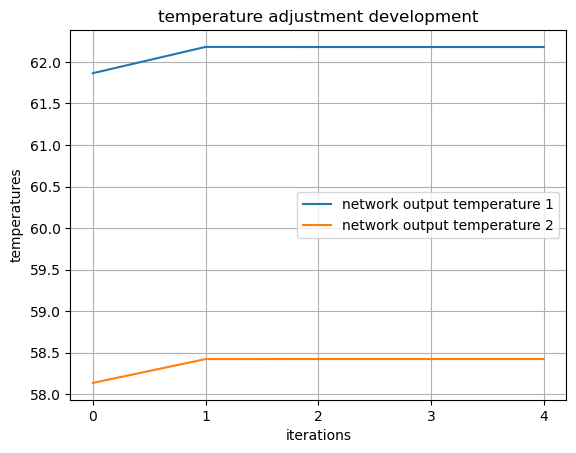

In [53]:
ex.vis_temperature_adjustment_development()

#### Darstellung des Temperaturverlaufs und Wärmestroms der einzelnen Apparate
Zur Analyse des Netzwerks kann der Temperaturverlauf der einzelnen Ströme oder des umgesetzten Wärmestroms hilfreich sein. 
Im gegebenen Beispiel zeigt sich, dass in den ersten 3 Zellen, die vom jeweiligen Strom durchlaufen werden, der gleiche Wärmestrom umgesetzt wird bzw. die Temperaturänderung innerhalb einer Zelle gleich ist. In der letzten Zelle ist die Temperaturdifferenz zwischen den Strömen so gering, dass nicht mehr so viel Wärmestrom übertragen wird.

Die Visualisierung des Temperaturverlaufs durch die Methode `vis_flow_temperature_development()` zeigt nur die Ein- und Austrittstemperaturen an den Zellen. Der lineare Verlauf dazwischen entspricht nicht dem tatsächlichen Temperaturverlauf innerhalb einer Zelle. Der übertragene Wärmestrom wird durch die Methode `vis_heat_flux()` visualisiert. Die Darstellung entspricht dem zuvor über `shape` definierten Layout des Netzwerks, und die Pfeile visualisieren, in welche Richtung der jeweilige Strom durch die Zellen fließt.

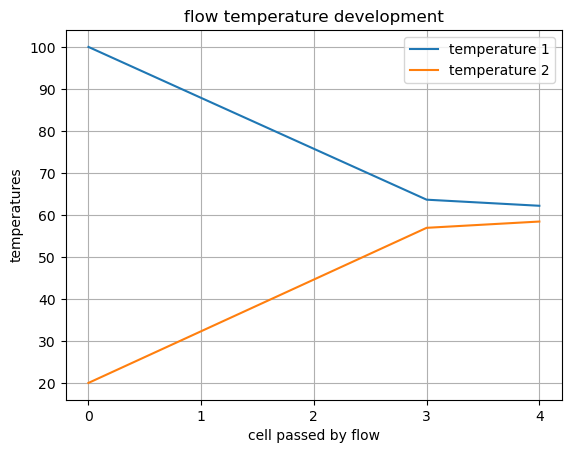

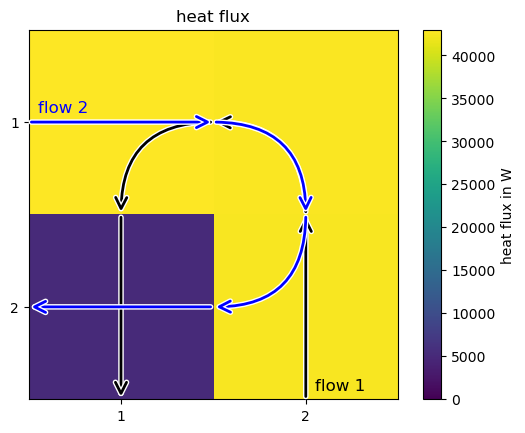

In [54]:
ex.vis_flow_temperature_development()
ex.vis_heat_flux()

### Betrachtung unterschiedlicher Stromführungen

Welche Ein- und Austrittspositionen am besten für die gegebenen Fluiddaten sind, kann anhand folgender Analyse beurteilt werden. Zu beachten ist, dass im Folgenden alle (theoretisch) möglichen Eintritts- und Austrittspositionen visualisiert werden. Ob und mit welcher Konstruktion dies auch in einem Rohrbündelwärmeübertrager umgesetzt werden kann, wird außer Acht gelassen. Weiterhin ist zu beachten, dass unterschiedliche Stromführungen eventuell auch besser durch andere Wärmeübertragertypen in den einzelnen Zellen angenähert werden können und berechnete Druckverluste von der genauen Stromführung abhängig sein können.

Die folgenden Visualisierungen zeigen daher nur die Möglichkeiten, sofern alle Zellen gleich behandelt werden. Durch Anpassen der einzelnen Zellen in den Setups kann eine genauere Beurteilung durchgeführt werden.

Es zeigt sich, dass die Setups, in denen in jeder Zelle der gleiche Wärmestrom übertragen wird, den höchsten Wirkungsgrad haben, was bedeutet, dass die Austrittstemperaturen die größte Temperaturdifferenz bezogen auf die Eintrittstemperaturen aufweisen.

#### Implementierung

Zunächst muss eine Methode `init_ex()` definiert werden, um die konstanten Daten des Wärmeübertragernetzwerks, wie oben beschrieben, zu initialisieren.
Um die unterschiedlichen Stromführungen zu bewerten, wird in einer Schleife dem Wärmeübertragernetzwerk, der Reihe nach verschiedene Stromführung zugewiesen. Dies kann entweder selbst definiert werden oder es wird auf die Methode `input_arrangements` der Klasse `ExchangerTwoFlow` zurückgegriffen, welche eine Liste aller Permutationen der implementierten Strömungseintritte erzeugt. Dabei muss darauf geachtet werden, dass nicht alle Kombinationen konstruktiv umsetzbar sind.
Ist das Netzwerk vollständig initialisiert, können die Temperaturen berechnet werden. Da im Folgenden keine textuelle Ausgabe des Netzwerks erzeugt wird, muss die Methode `_adjust_temperature()` manuell ausgeführt werden. Das berechnete Netzwerk wird nun in einer Liste abgespeichert.

Die Funktion `vis_setups(network_list: list, plot_function, fig_title: str = "", **ax_parameters)` ermöglicht es, eine Liste von mehreren Netzwerken zu visualisieren. Dazu muss die Liste der Wärmeübertragernetzwerke übergeben werden und der Name der gewünschten Plot-Methode, die in der jeweiligen Klasse des Netzwerks implementiert sein muss. Zusätzlich können noch Parameter für den Plot übergeben werden.
Im Folgenden wird beispielsweise der minimale und maximale Wärmestrom übergeben, um die Achsenparameter aller Plots gleich anzupassen und eine bessere Vergleichbarkeit der Heatmaps zu gewährleisten.

In [55]:
def init_ex():
    W_dot_1 = 3500
    fluid_1 = Fluid("Water", pressure=101420, temperature=273.15 + 100)
    flow_1 = Flow(fluid_1, W_dot_1/fluid_1.specific_heat)

    W_dot_2 = 3500
    fluid_2 = Fluid("Water", temperature=273.15 + 20)
    flow_2 = Flow(fluid_2, W_dot_2/fluid_2.specific_heat)

    kA = 4000
    ex = ExchangerEqualCells((2, 2), 'CrossFlowOneRow', flow_1=flow_1, flow_2=flow_2,total_transferability=kA)
    return ex

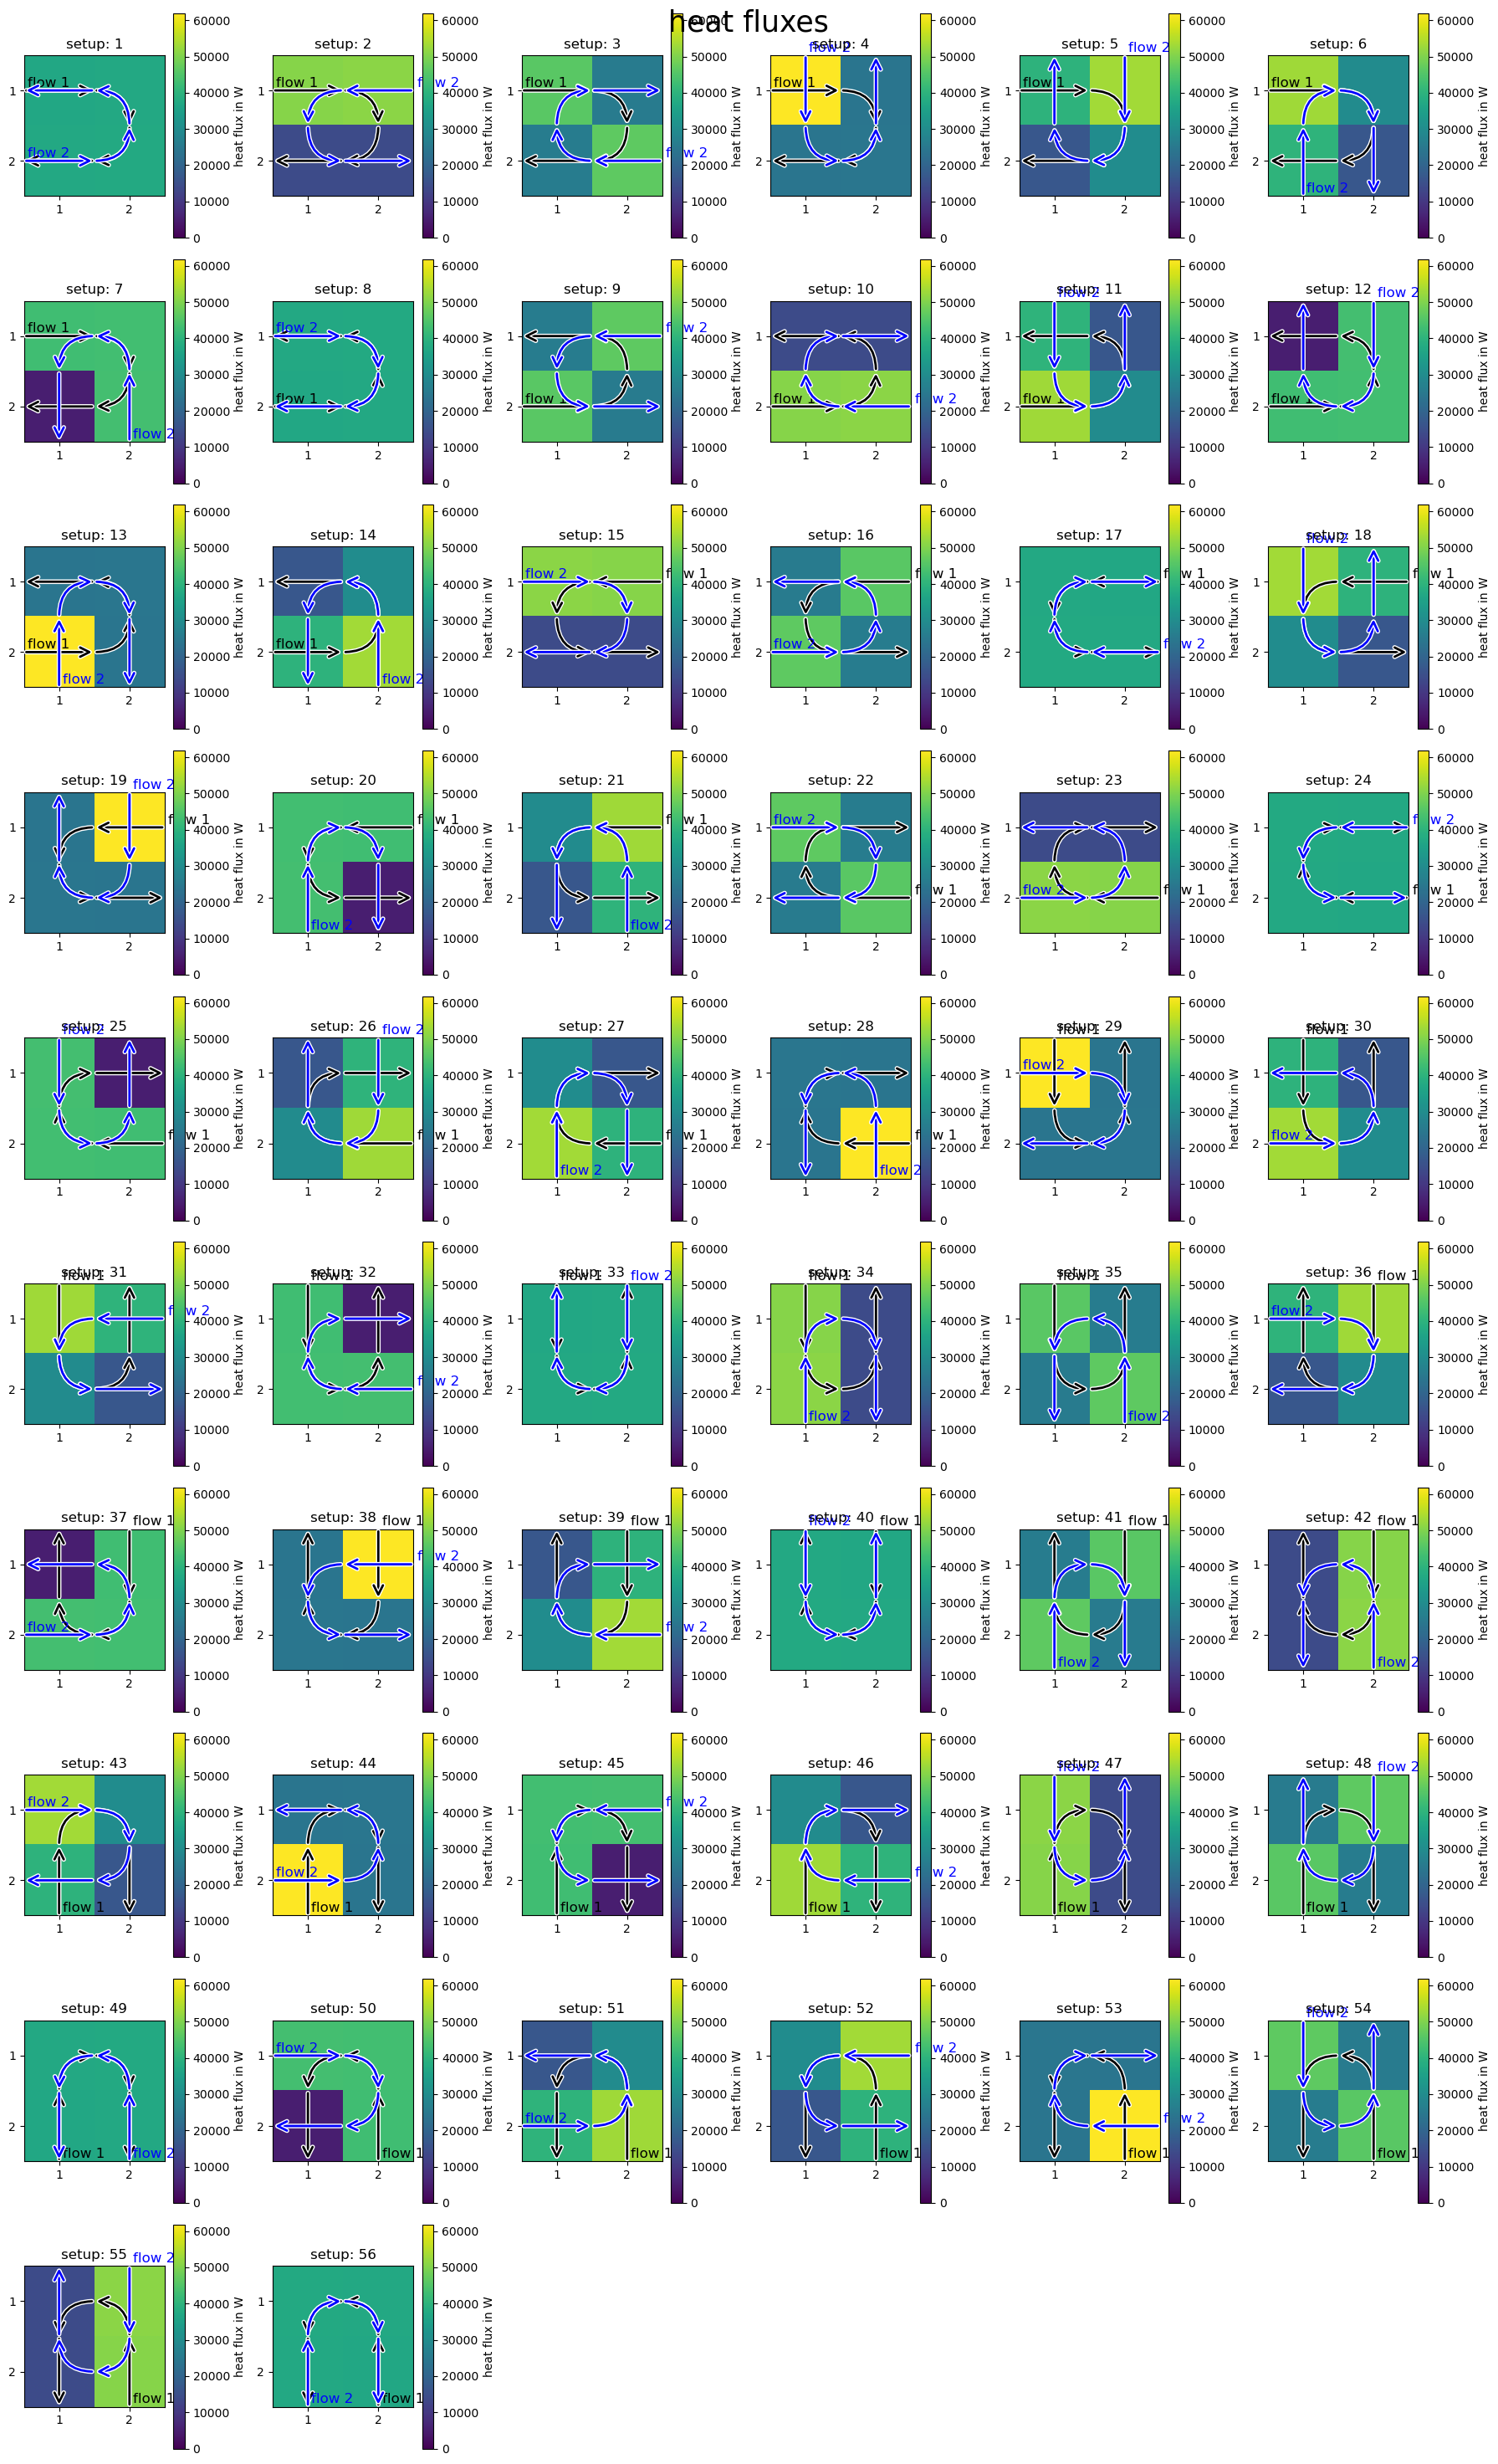

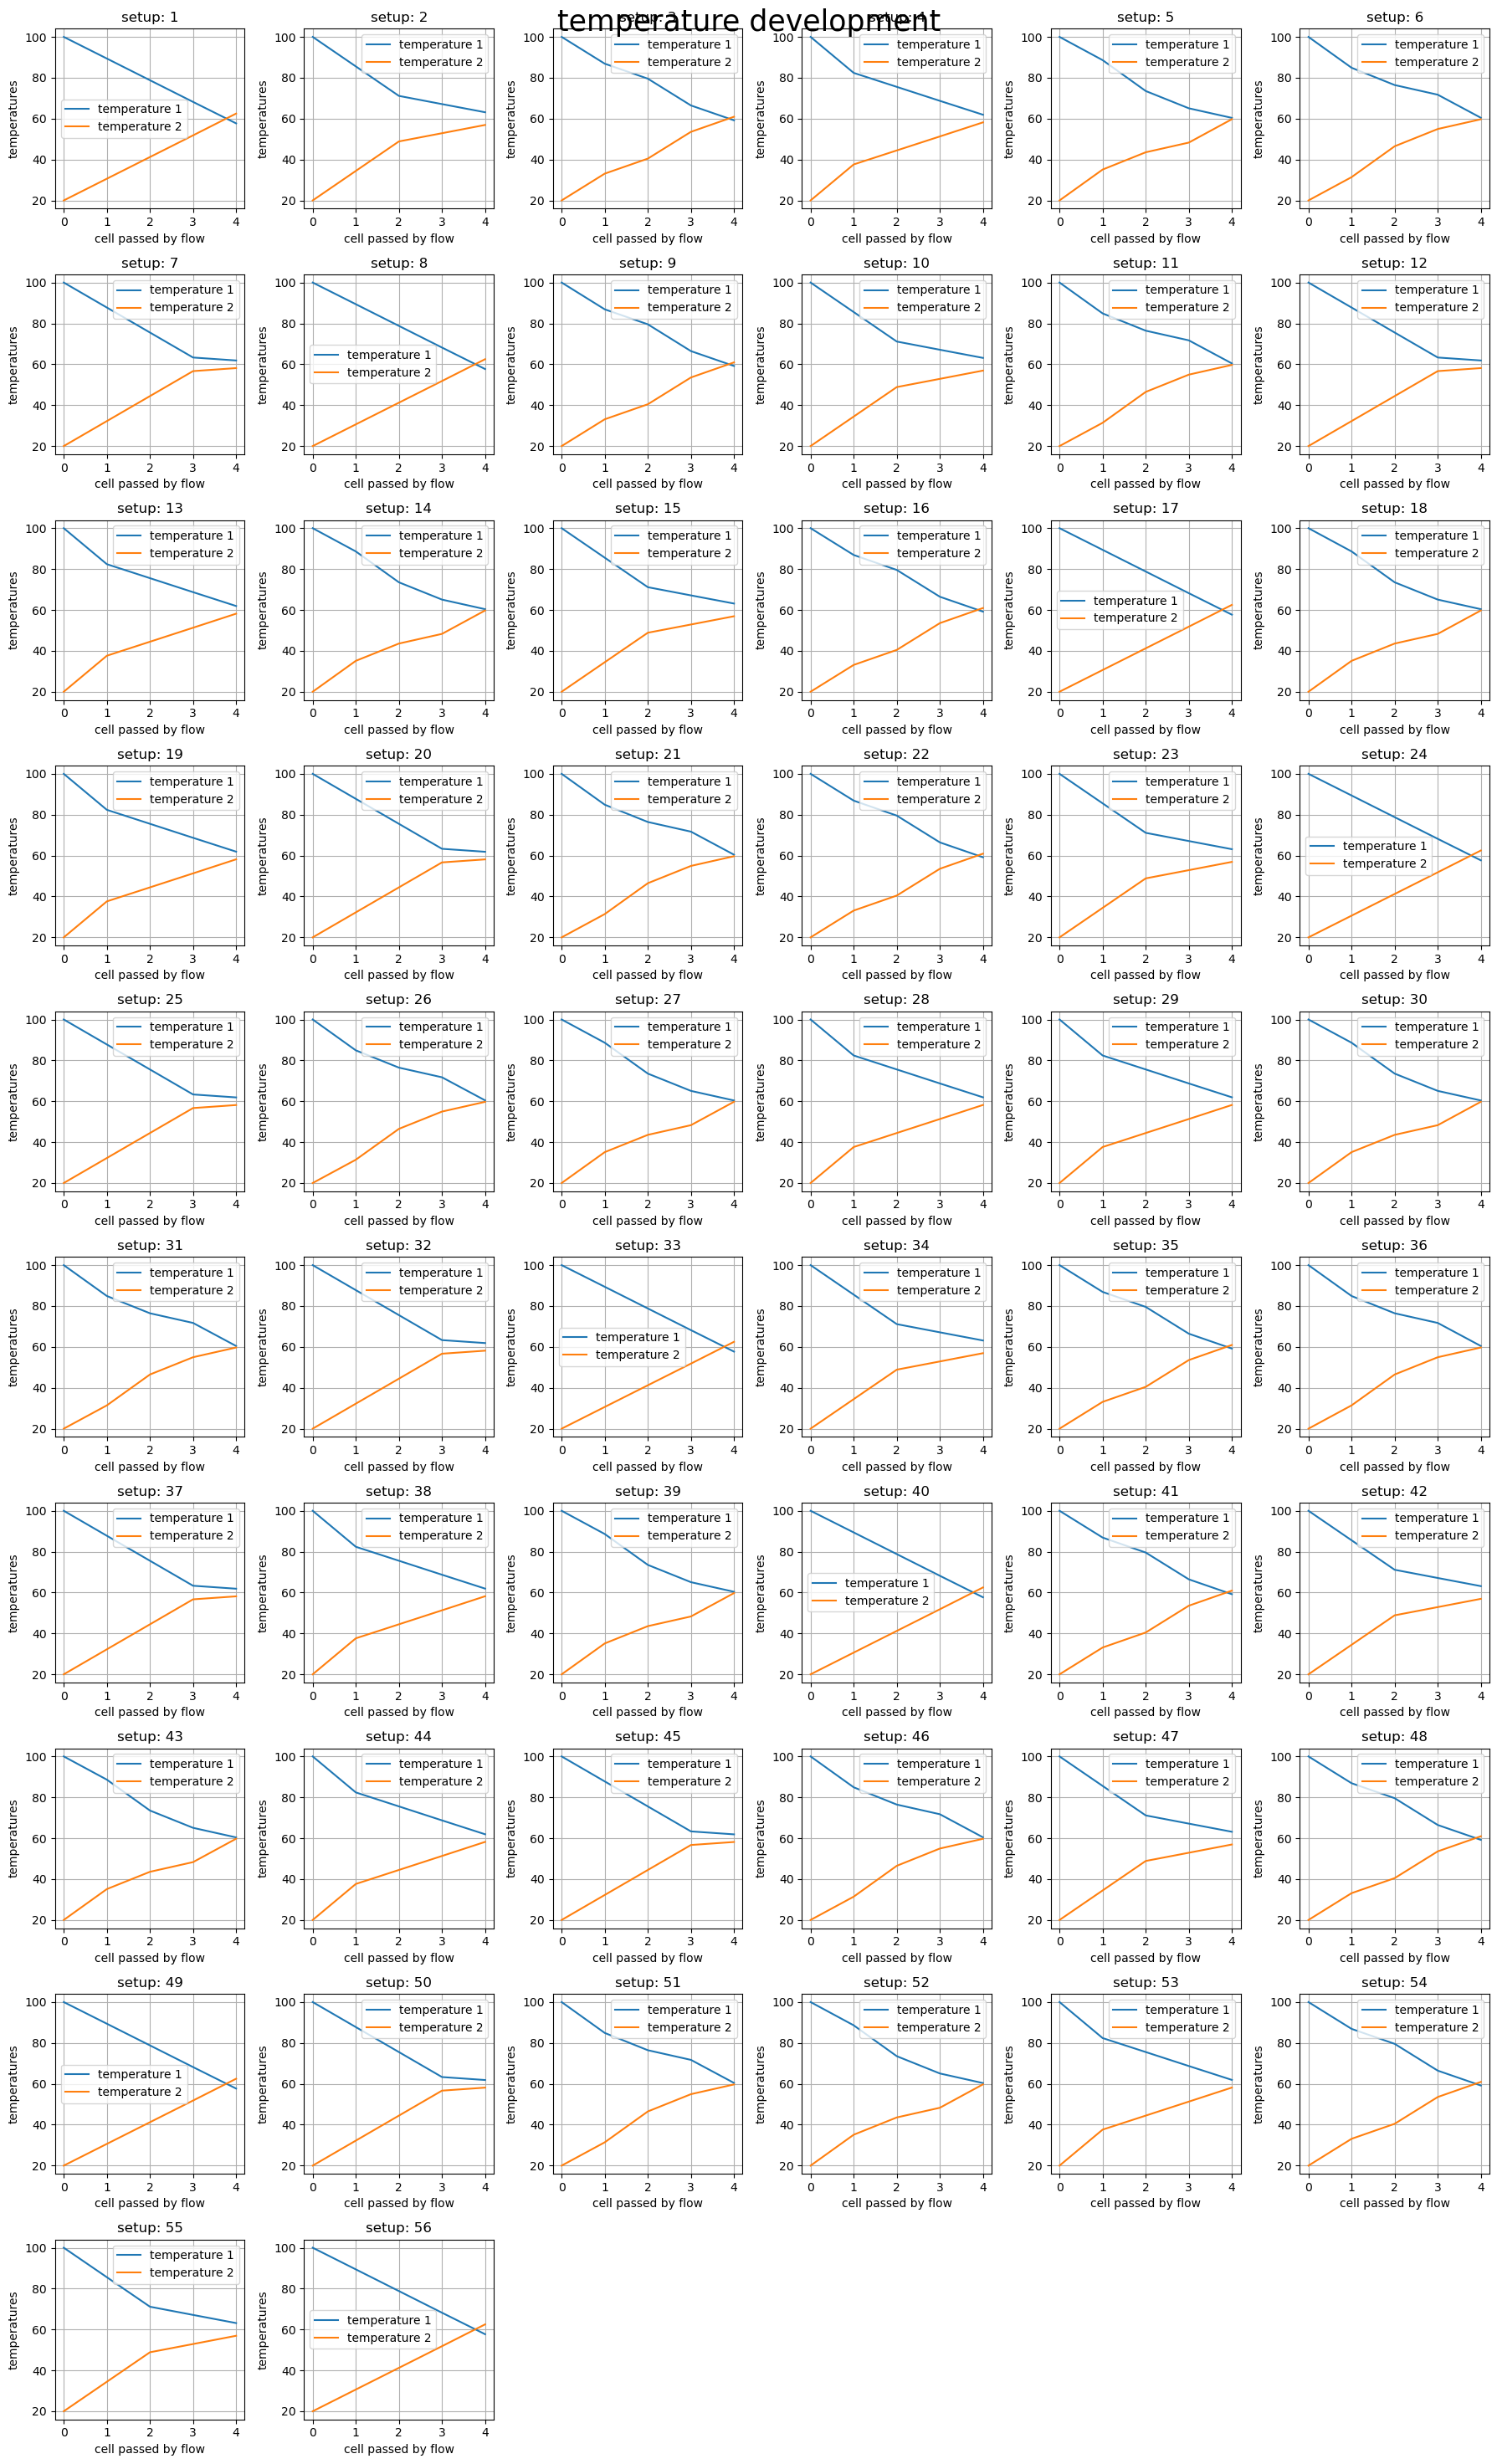

In [56]:
networks = []
for inp in ExchangerTwoFlow.input_arrangements():
    netw = init_ex()
    netw.flow_order_1 = inp[0]
    netw.flow_order_2 = inp[1]
    netw._adjust_temperatures()
    networks.append(netw)

# calculate min and max heatflow of all available networks
ax_parameters_heat = {'vmin': 0, 'vmax': max([heat_flux_repr(netw.layout_matrix).max() for netw in networks])}
vis_setups(networks, 'vis_heat_flux', fig_title='heat fluxes', **ax_parameters_heat)
vis_setups(networks, 'vis_flow_temperature_development', fig_title='temperature development')

## Rohrbündelwärmeübertrager mit mehreren Umlenkungen
Das folgende Beispiel zeigt, wie ein Rohrbündelwärmeübertrager mit mehren Stromumlenkungen berechnet werden kann. Das Beispiel ist aus Kapitel 3.5.1, T. Kuppan. Heat Exchanger Design Handbook. Second. Boca Raton, FL: CRC Press, 2013.entnommen.

<figure>
  <img src="./images/heatexchanger_network_baffles.PNG" alt="Rohrbündelwärmeübertrager" width="650" height="250">
  <figcaption> Stromführung eines Rohrbündelwärmeübertragers mit mehreren veritkalen Stromumlenkungsbleche (entnommen aus T. Kuppan, Heat Exchanger Design Handbook Second Edition, 2013, Seite 330)</figcaption>
</figure>

Zunächst müssen wiederum die konstruktiven Merkmale sowie die Fluiddaten des Rohrbündelwärmeübertragers definiert werden.


#### Implementierung

Die Definition der Fluide erfolgt, wie bereits zuvor beschrieben.

Die gesamte Konstruktion wird durch die Klasse `Assembly` definiert. Dazu sind folgende Eigenschaften zu übergeben:

- Das Rohrbündel kann, wie in [`standard_heatexchangers.ipynb`](standard_heatexchangers.ipynb) beschrieben, definiert werden.
- Über die Klasse `Shell` bzw. deren Subklassen wie z.B. `SquareShellGeometry` kann die Größe des Mantels definiert werden.

Im gegebenen Fall wird für das Rohrbündel keine Rohrlänge angegeben, sondern wird über die Länge des Mantels und die Anzahl der Umlenkungen berechnet.

- Die Fluid-Eintritte können mithilfe der Klasse `Inlets` definiert werden. Die Konvention ist dieselbe wie bei der zuvor beschriebenen Stromführung, jedoch ohne die letzten zwei Stellen. Diese ergeben sich aus dem konstruktiven Aufbau und sind durch den mantelseitigen `shell_inlet` oder den Rohrbündeleinlass `tube_inlet` definiert.
- Die vertikalen Sperren bzw. Stromumlenkungsbleche können für die Klasse `Baffle` bzw. deren Subklassen definiert werden. Dazu muss auf jeden Fall die Anzahl definiert werden und eventuell noch zusätzliche Parameter.
- Die Anzahl der Rohrdurchgänge, also die Anzahl der horizontalen Stromdurchführungen, wird über `tube_passes` definiert.

Ist keine Rohrlänge angegeben, wird diese basierend auf der Mantelgeometrie und den Rohrdurchführungen berechnet.


In [57]:
W_dot_1 = 3500
fluid_1 = Fluid("Water", pressure=101420, temperature=273.15 + 100)
flow_1 = Flow(fluid_1, W_dot_1/fluid_1.specific_heat)

W_dot_2 = 3500
fluid_2 = Fluid("Water", temperature=273.15 + 20)
flow_2 = Flow(fluid_2, W_dot_2/fluid_2.specific_heat)

In [58]:
shell = SquareShellGeometry(length=5, width_in=2, height_in=1)
pipe = StraightPipe(10e-3, 13e-3)
pipe_layout = PipeLayout(pipe, 20)

inlets = Inlets(shell_inlet='ul', tube_inlet='dr')

baffle = SegmentalBaffle(number=6)

assembly = Assembly(shell, pipe_layout, tube_passes=2,baffle=baffle,inlets=inlets)
assembly.heat_transfer_coefficient = 500

Damit können alle notwendigen Daten mithilfe der Zellenmethode berechnet werden:

Die zwei definierten Ströme und die Konstruktion können der Funktion `auto_create_exchanger()` übergeben werden. Der erste Strom `flow_1` stellt dabei den äußeren, also mantelseitigen, und der zweite `flow_2` den Strom in den Rohrbündeln dar. Die Funktion erzeugt ein `ExchangerEqualCells`-Objekt, das einem Rohrbündelwärmeübertrager, wie zuvor definiert, entspricht.


In [59]:
ex_layout=auto_create_exchanger(flow_1=flow_1,flow_2=flow_2,assembly=assembly)
print(ex_layout.extended_info())

Heat Exchanger Network:
	cell numbers: 14
	heat fluxs q_1=131.09 kW,	q_2=-131.09 kW
input flows: n=2
	flow 0: Water, temp= 100.00°C
	flow 1: Water, temp= 20.00°C
output flows: n=2
	flow 0: Water, temp= 62.87°C
	flow 1: Water, temp= 57.71°C

cell:0

heat exchanger:
	id = 2629143606944
	type: CrossFlowOneRow
Flows:
Flow 1:
Flow: id = 2629204993568
	mass flow = 0.83141 kg/s
	heat capacity flow: W_dot = 3503.17037 W/K
	heat flow: Q_dot = 13.32112 kW

Input Fluid:
	Fluid: title = Water, id = 2629204986272
	p = 101420 Pa
	t = 100.0 °C
Output Fluid:
	Fluid: title = Water, id = 2629204999376
	p = 101420 Pa
	t = 96.19742199336883 °C

Flow 2:
Flow: id = 2629176724976
	mass flow = 0.82941 kg/s
	heat capacity flow: W_dot = 3467.23813 W/K
	heat flow: Q_dot = -13.32111 kW

Input Fluid:
	Fluid: title = Water, id = 2629202926592
	p = 101325 Pa
	t = 44.21568586750652 °C
Output Fluid:
	Fluid: title = Water, id = 2629176736064
	p = 101325 Pa
	t = 48.05767136882645 °C

Parameters:

dimensionless parameter

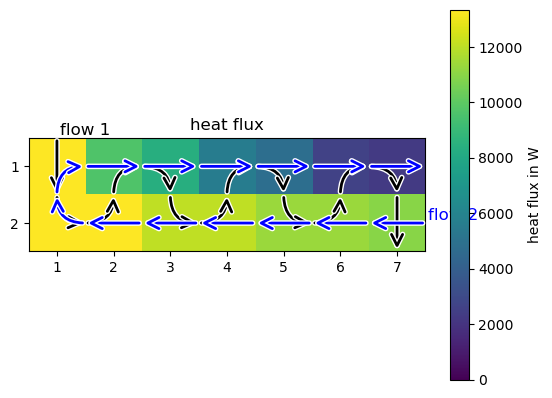

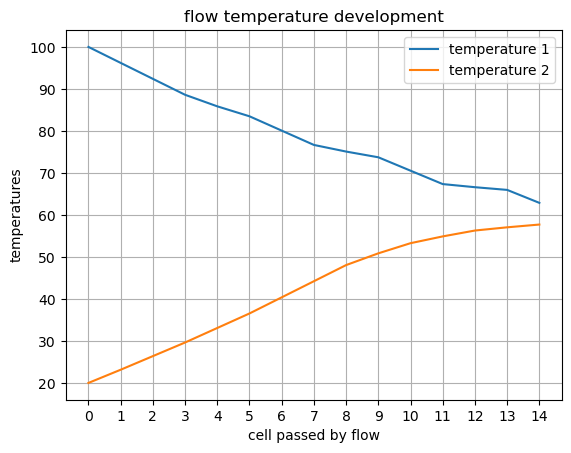

In [60]:
ex_layout.vis_heat_flux()
ex_layout.vis_flow_temperature_development()

Es zeigt sich, dass die Temperaturverläufe gut mit denen in der folgenden Abbildung übereinstimmen. Nur die Darstellungsart unterscheidet sich: Oben werden die Temperaturen über durchflossenen Zellen dargestellt, während unten die Darstellung über die Länge des Rohrbündelwärmeübertragers erfolgt.

<figure>
  <img src="./images/heatexchanger_network_baffles_temps.PNG" alt="Temperaturverlauf" width="650" height="450">
  <figcaption> Temperaturverlauf der Fluidströme dargestellt über die Länge des Rohrbündelwärmeübertragers (entnommen aus T. Kuppan, Heat Exchanger Design Handbook Second Edition, 2013, Seite 330)</figcaption>
</figure>